In [1]:
from pyathena import connect
import pandas as pd
import configparser

In [46]:
config = configparser.ConfigParser()
config.read('../access_keys_shreya.cfg')
AWS_ACCESS_KEY = config.get('aws', 'aws_access_key')
AWS_SECRET_KEY = config.get('aws', 'aws_secret_key')

In [47]:
from six.moves.urllib.parse import quote_plus
from sqlalchemy.engine import create_engine

SCHEMA_NAME = "yelp"
S3_STAGING_DIR = "s3://sairin.yelp.dataset/dataset"
AWS_REGION = "us-west-1"
conn_str = (
    "awsathena+rest://{aws_access_key_id}:{aws_secret_access_key}@"
    "athena.{region_name}.amazonaws.com:443/"
    "{schema_name}?s3_staging_dir={s3_staging_dir}&work_group=primary"
)


# Create the SQLAlchemy connection. Note that you need to have pyathena installed for this.
engine = create_engine(
    conn_str.format(
        aws_access_key_id=quote_plus(AWS_ACCESS_KEY),
        aws_secret_access_key=quote_plus(AWS_SECRET_KEY),
        region_name=AWS_REGION,
        schema_name=SCHEMA_NAME,
        s3_staging_dir=quote_plus(S3_STAGING_DIR),
    )
)
athena_connection = engine.connect()


In [4]:
query_business = """
        SELECT * 
        FROM yelp.balanced_reviews_dataset
        """

#df_balanced_data = pd.read_sql(query_business, athena_connection)


In [59]:
#df_balanced_data.to_pickle('df_top_fifty_restaurant.pkl')
df_balanced_data = pd.read_pickle('df_top_fifty_restaurant.pkl')

# Balanced Dataframe containing rating of users

In [60]:
df_balanced_data.head()

,business_id,stars,text
0,9kv9JpLhzkN3UeWZDrsmEA,3.0,Ate at the bar late one evening. The food was...
1,8kUh6TROemLfbVR_ewVVLg,2.0,ive gone here more than 10 times. the first f...
2,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Went here Saturday for drag brunch, we had 8 p..."
3,9kv9JpLhzkN3UeWZDrsmEA,3.0,Turns out they randomly close the pool down wh...
4,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Totally awesome experience. Very New Orleans ""..."


# Histogram Plot Of Balanced Dataframe 

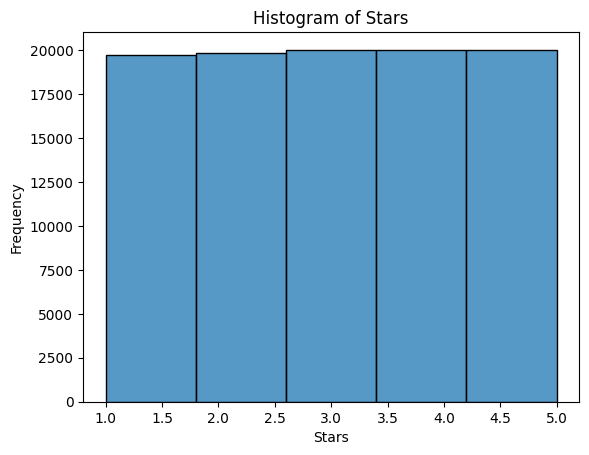

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram
sns.histplot(data=df_balanced_data, x='stars', bins=5)
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Histogram of Stars')
plt.show()


In [62]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sairindhri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Generating Bert Embedding On Each Sentence Of Text

In [64]:
from sentence_transformers import SentenceTransformer
# import tqdm.notebook as tq
from tqdm import tqdm
from time import sleep
import numpy as np

# Avoid running this code block, instead take the data from the pickle
runThisBlock = False


if runThisBlock:
    # Load the pre-trained model
    bert_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

    # Create a new column for embeddings
    df_balanced_data['embeddings'] = None

    def generate_mean_embedding(row):
        review = row
        review_sentances = nltk.sent_tokenize(review)

        embeddings = bert_model.encode(review_sentances)

        mean_embeddings =  np.mean(embeddings, axis=0)
        return mean_embeddings

    total_reviews = df_balanced_data.shape[0]
    progress_bar = tqdm(total=total_reviews, desc='Processing Reviews')

    for index, row in df_balanced_data.iterrows():
        review_text = row['text']
        mean_embeddings=generate_mean_embedding(review_text)
        df_balanced_data.at[index, 'embeddings'] = mean_embeddings
        # Update the progress bar
        progress_bar.update(1)
        
    # Close the progress bar
    progress_bar.close()


    df_balanced_data.head()

    df_balanced_data.to_pickle("intermediate_data/bert_generated_embeddings_balanced_dataframe.pkl")

# Saving Generated Embedding File in Pickle

In [65]:
# Load DataFrame from pickle file
df_restored = pd.read_pickle("intermediate_data/bert_generated_embeddings_balanced_dataframe.pkl")

# Now you can use 'df' just like a regular DataFrame

df_restored.head()

,business_id,stars,text,embeddings
0,9kv9JpLhzkN3UeWZDrsmEA,3.0,Ate at the bar late one evening. The food was...,"[0.02110215, 0.015082884, 0.027772486, 0.04898..."
1,8kUh6TROemLfbVR_ewVVLg,2.0,ive gone here more than 10 times. the first f...,"[0.053978473, -0.005075182, 0.03789233, 0.0295..."
2,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Went here Saturday for drag brunch, we had 8 p...","[0.05708591, -0.007079023, 0.02999837, 0.03157..."
3,9kv9JpLhzkN3UeWZDrsmEA,3.0,Turns out they randomly close the pool down wh...,"[0.01065718, 0.014424983, 0.042207252, 0.02751..."
4,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Totally awesome experience. Very New Orleans ""...","[0.029420882, 0.032237433, 0.026742732, 0.0395..."


# Creating New Dataframe By Taking Subset Of Columns(text, stars and embeddings on each text)

In [66]:
df_final=df_restored[['text','stars','embeddings']]
df_final.head()

,text,stars,embeddings
0,Ate at the bar late one evening. The food was...,3.0,"[0.02110215, 0.015082884, 0.027772486, 0.04898..."
1,ive gone here more than 10 times. the first f...,2.0,"[0.053978473, -0.005075182, 0.03789233, 0.0295..."
2,"Went here Saturday for drag brunch, we had 8 p...",3.0,"[0.05708591, -0.007079023, 0.02999837, 0.03157..."
3,Turns out they randomly close the pool down wh...,3.0,"[0.01065718, 0.014424983, 0.042207252, 0.02751..."
4,"Totally awesome experience. Very New Orleans ""...",3.0,"[0.029420882, 0.032237433, 0.026742732, 0.0395..."


In [78]:
len_embedding=len(df_final['embeddings'][0])
len_embedding

384

# Mapping stars to different categorical variable for classification machine learning

In [67]:
def map_sentiment(star_rating):
    if star_rating in [1, 2]:
        return -1
    elif star_rating == 3:
        return 0
    elif star_rating in [4, 5]:
        return 1

# Apply the mapping function to create the 'sentiment' column
df_final['sentiment'] = df_final['stars'].apply(map_sentiment)
df_final.head(3)

,text,stars,embeddings,sentiment
0,Ate at the bar late one evening. The food was...,3.0,"[0.02110215, 0.015082884, 0.027772486, 0.04898...",0
1,ive gone here more than 10 times. the first f...,2.0,"[0.053978473, -0.005075182, 0.03789233, 0.0295...",-1
2,"Went here Saturday for drag brunch, we had 8 p...",3.0,"[0.05708591, -0.007079023, 0.02999837, 0.03157...",0


# Split Dataset into Train And Test Data

In [82]:
from sklearn.model_selection import train_test_split
def splitData(df, frac=1.0):
    data = df.sample(frac=frac, replace=False, random_state=42)
    train_df, test_df = train_test_split(data, test_size=0.1, random_state=42)

    return train_df, test_df

train_df, test_df = splitData(df_final, .15)

In [83]:
print(train_df.shape)
print(test_df.shape)

(13455, 4)
(1496, 4)


In [84]:
# Convert lists of embeddings into a 2D numpy array
X_train = np.stack(train_df['embeddings'].values)

# The 'stars' column is your target variable
y_train = train_df['sentiment'].values

X_train

array([[ 0.01360777,  0.02503986,  0.05366267, ...,  0.02928971,
        -0.10079049,  0.02161232],
       [-0.03659196,  0.04094673, -0.0031523 , ..., -0.00847535,
        -0.08326593,  0.02175865],
       [-0.01635939,  0.02145226,  0.02421339, ..., -0.01094579,
        -0.06452049,  0.03311194],
       ...,
       [ 0.00387106,  0.02537922, -0.0020346 , ...,  0.02327003,
        -0.06491643, -0.0276749 ],
       [ 0.00402074, -0.0191915 ,  0.0253267 , ..., -0.00715511,
        -0.06079474,  0.02620239],
       [-0.06658947,  0.03480976,  0.03515029, ..., -0.02315255,
        -0.00623002, -0.00574938]], dtype=float32)

In [85]:
y_train

array([ 0,  1,  0, ...,  1, -1, -1])

In [86]:
X_test = np.stack(test_df['embeddings'].values)

# # The 'stars' column is your target variable
y_test = test_df['sentiment'].values



# Bar plot showing distribution of rating in different categories

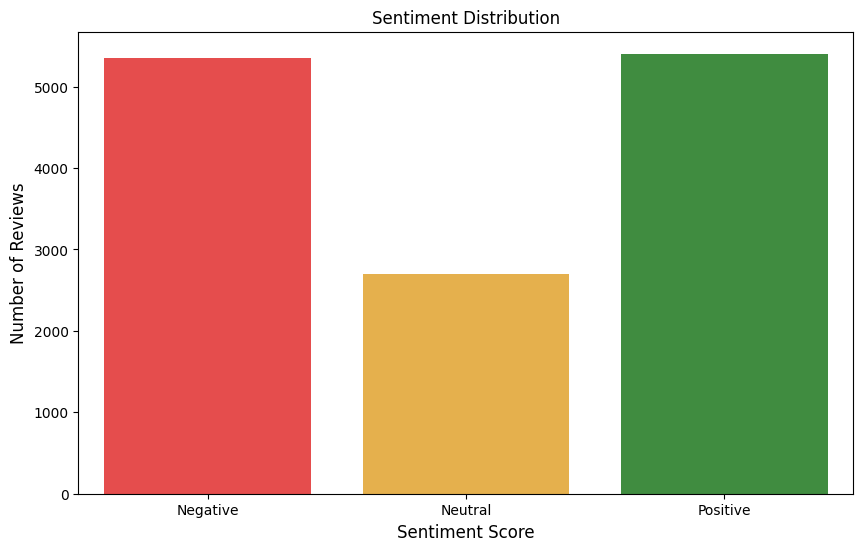

In [87]:
# Count the number of each sentiment score in your dataset
sentiment_counts = train_df['sentiment'].value_counts().sort_index()

# Generate a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, alpha=0.8,palette=['red', 'orange', 'green'])

# Replace numeric labels with text labels
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

plt.title('Sentiment Distribution')
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Sentiment Score', fontsize=12)
plt.show()



Mean Value (0.1)    
    Model	            Accuracy	Precision	Recall	    F1 Score
0	Logistic Regression	0.774323	0.753083	0.774323	0.754447
1	Random Forest	    0.754263	0.734307	0.754263	0.701530
2	SVM	                0.792377	0.780292	0.792377	0.783531

Mean Value (0.2)
	Model	            Accuracy	Precision	Recall	    F1 Score
0	Logistic Regression	0.781344	0.762993	0.781344	0.762292
1	Random Forest	    0.739218	0.715532	0.739218	0.684479
2	SVM	                0.783852	0.766595	0.783852	0.768806

Mean Value (0.3)
	Model	            Accuracy	Precision	Recall	F1 Score
0	Logistic Regression	0.778001	0.755479	0.778001	0.758309
1	Random Forest	    0.739552	0.698251	0.739552	0.685958
2	SVM	                0.783684	0.765683	0.783684	0.770033

Max Pooling	(0.3)
    Model	            Accuracy	Precision	Recall	    F1 Score
0	Logistic Regression	0.752257	0.724362	0.752257	0.729491
1	Random Forest	    0.718823	0.706306	0.718823	0.646197
2	SVM	                0.752925	0.727127	0.752925	0.732776

### Model Evaluation without hyperparameter tunning

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import pandas as pd

def train_model(model, X_train, y_train):
    model.fit(X_train,y_train)
    return model

def evaluate_model(model, X_test, y_test):
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)

    # Append the metrics to the DataFrame
    return [accuracy, precision, recall, f1]




k-fold cross validation

In [100]:
def k_fold_train_and_evaluate(model, X_train, y_train, n_splits=5):
    kf = KFold(n_splits=n_splits)

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for train_index, test_index in kf.split(X_train):
        X_train_new, X_val = X_train[train_index], X_train[test_index]
        # print('X_train',X_train_new)
        # print('X_val', X_val)
        y_train_new, y_val = y_train[train_index], y_train[test_index]
        # print('Y_train',y_train_new)
        # print('Y_val', y_val)

        model = train_model(model, X_train_new, y_train_new)
        metrics = evaluate_model(model, X_val, y_val)
        print('metric',metrics)

        accuracy_list.append(metrics[0])
        precision_list.append(metrics[1])
        recall_list.append(metrics[2])
        f1_list.append(metrics[3])

    results = {
        "accuracy_mean": np.mean(accuracy_list),
        "accuracy_std": np.std(accuracy_list),
        "precision_mean": np.mean(precision_list),
        "precision_std": np.std(precision_list),
        "recall_mean": np.mean(recall_list),
        "recall_std": np.std(recall_list),
        "f1_mean": np.mean(f1_list),
        "f1_std": np.std(f1_list)
    }

    return results


In [80]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', random_state=42)
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)

y_train_boost=y_train+1
y_test_boost=y_test+1

lr_model=train_model(lr_model, X_train, y_train)
rf_model=train_model(rf_model, X_train, y_train)
svm_model=train_model(svm_model, X_train, y_train)
gb_model=train_model(gb_model, X_train, y_train_boost)
adaboost_model=train_model(adaboost_model, X_train, y_train_boost)

# Initialize an empty DataFrame to store the performance metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

metrics_df.loc[len(metrics_df.index)] = ["Logistic Regression"] + evaluate_model(lr_model, X_test, y_test)
metrics_df.loc[len(metrics_df.index)] = ["Random Forest"] + evaluate_model(rf_model, X_test, y_test)
metrics_df.loc[len(metrics_df.index)] = ["SVM"] + evaluate_model(svm_model, X_test, y_test)


# Evaluate and store performance metrics
metrics_df.loc[len(metrics_df.index)] = ["Gradient Boosting"] + evaluate_model(gb_model, X_test, y_test_boost)
metrics_df.loc[len(metrics_df.index)] = ["AdaBoost"] + evaluate_model(adaboost_model, X_test,  y_test_boost)



/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [81]:
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.780080,0.710296,0.685708,0.682271
1,Random Forest,0.741979,0.616786,0.617346,0.578043
2,SVM,0.796123,0.736307,0.715107,0.717307
3,Gradient Boosting,0.772059,0.702058,0.680464,0.677608
4,AdaBoost,0.754011,0.683045,0.672789,0.672277


k-fold evaluation

In [109]:
def append_result_to_dataframe(name, metrics_dict, df=None):
    # split the dictionary into a multi-indexed dictionary
    multi_indexed_dict = {(metric.split('_')[0], metric.split('_')[1]): value 
                          for metric, value in metrics_dict.items()}
    
    # create a new DataFrame for the current row of data
    row_df = pd.DataFrame(multi_indexed_dict, index=[name])

    if df is None:
        return row_df
    else:
        return pd.concat([df, row_df])

In [115]:
metrics_cross_validation_Logistic_df = pd.DataFrame(columns=['Model', 'Metric', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
metrics_cross_validation_RandomForest_df = pd.DataFrame(columns=['Model', 'Metric', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
metrics_cross_validation_svm_df = pd.DataFrame(columns=['Model', 'Metric', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
# metrics_cross_validation_gb_df = pd.DataFrame(columns=['Model', 'Metric', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
# metrics_cross_validation_ada_df = pd.DataFrame(columns=['Model', 'Metric', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results_logistic = k_fold_train_and_evaluate(lr_model, X_train, y_train)

result_rf=k_fold_train_and_evaluate(rf_model, X_train, y_train)
result_svm=k_fold_train_and_evaluate(svm_model, X_train, y_train)
# result_gb=k_fold_train_and_evaluate(gb_model, X_train, y_train_boost)
# result_ada=k_fold_train_and_evaluate(adaboost_model, X_train, y_train_boost)


metrics_cross_validation_Logistic_df = append_result_to_dataframe("Logistic Regression", results_logistic)
metrics_cross_validation_RandomForest_df = append_result_to_dataframe("Random Forest", result_rf)
metrics_cross_validation_svm_df = append_result_to_dataframe("SVM", result_svm)
# metrics_cross_validation_gb_df = append_result_to_dataframe("GradientBoost", result_gb)
# metrics_cross_validation_ada_df = append_result_to_dataframe("AdaBoost", result_ada)


metric [0.7614269788182831, 0.708263360664079, 0.6851179524631045, 0.6782620797691082]
metric [0.7770345596432553, 0.7168888850970768, 0.6975693974408221, 0.6977335349152837]
metric [0.7740616871051653, 0.7177829797920499, 0.695403294869771, 0.6955962393711269]
metric [0.7725752508361204, 0.7239730920671675, 0.6952894573391162, 0.6923199949800555]
metric [0.7751765143069491, 0.7257982951925123, 0.6958982834505157, 0.6922587424190141]


/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


metric [0.7253808992939428, 0.6761759393436915, 0.6254349392480028, 0.5849090418566923]


/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


metric [0.7417316982534374, 0.6724850199912104, 0.6326567750700457, 0.6083244138972187]


/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


metric [0.7406168710516536, 0.6703556150167415, 0.6297082055904103, 0.6004263713999474]


/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


metric [0.7216648086213303, 0.6446746706578167, 0.6168497135700989, 0.5780658820210574]


/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


metric [0.7320698625046451, 0.6412214528756517, 0.6243971458763343, 0.583546894411163]
metric [0.7677443329617243, 0.7160848294476313, 0.7001165115381304, 0.6979376745166218]
metric [0.781122259383129, 0.7243910777236119, 0.7131983245998695, 0.7152428643796142]
metric [0.7852099591230026, 0.7309146753033594, 0.717315519764688, 0.7195867821502238]
metric [0.7807506503158677, 0.7344481605351171, 0.7133749266388897, 0.7144541582092306]
metric [0.7770345596432553, 0.7289818137902451, 0.7080944147784564, 0.7087564249386098]


In [117]:
# First, create a list that contains all your dataframes
dataframes = [
    metrics_cross_validation_Logistic_df, 
    metrics_cross_validation_RandomForest_df, 
    metrics_cross_validation_svm_df
   
]

# Then, concatenate them all into one
metrics_cross_validation_df = pd.concat(dataframes)
metrics_cross_validation_df.head()

accuracy           precision              recall  \
                         mean       std      mean       std      mean   
Logistic Regression  0.772055  0.005510  0.718541  0.006182  0.693856   
Random Forest        0.732293  0.007990  0.660983  0.014883  0.625809   
SVM                  0.778372  0.005911  0.726964  0.006335  0.710420   

                                     f1            
                          std      mean       std  
Logistic Regression  0.004444  0.691234  0.006808  
Random Forest        0.005376  0.591055  0.011392  
SVM                  0.005926  0.711196  0.007472

feature Importance

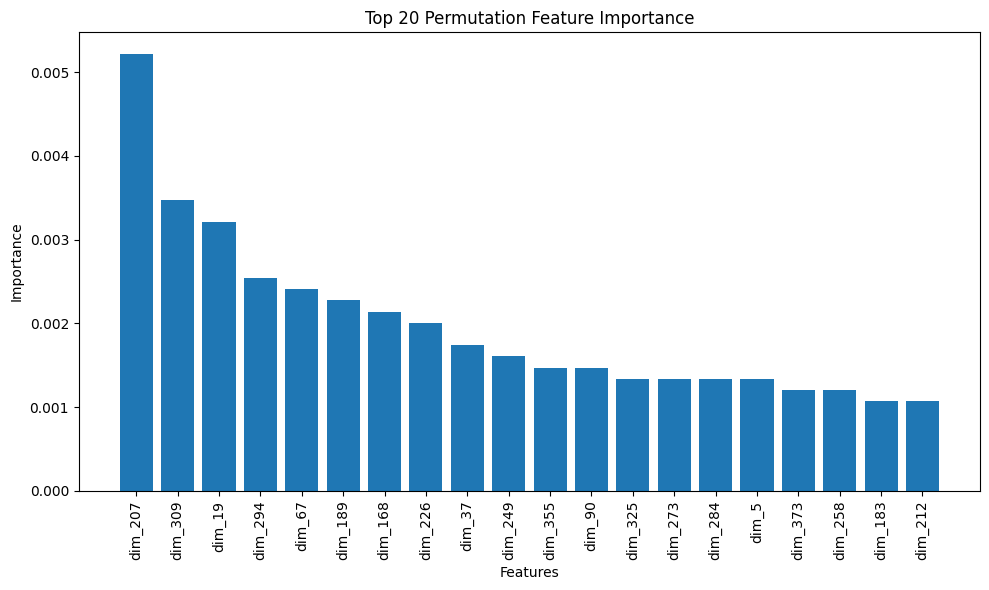

In [125]:
from sklearn.inspection import permutation_importance

# Assuming each BERT embedding has 384 dimensions
column_names = ["dim_" + str(i) for i in range(X_train.shape[1])]

# Compute permutation feature importance
# result = permutation_importance(svm_model, X_test, y_test, n_repeats=5, n_jobs=-1, random_state=42)

feature_importance = result.importances_mean

# Select the top N important features
top_n = 20  # Specify the number of top features to display
top_indices = feature_importance.argsort()[-top_n:][::-1]
top_importance = feature_importance[top_indices]
top_features = [column_names[i] for i in top_indices]

# Plot the top N important features in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_features)), top_importance)
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top {} Permutation Feature Importance'.format(top_n))
plt.tight_layout()
plt.show()

Based on this we can conclude that SVM works best

In [255]:
from sklearn.metrics import classification_report, confusion_matrix

def classification_report_model(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Generate and print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, zero_division=1))

def confusion_matrix_model(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Generate and print the confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))


In [256]:
classification_report_model("Logistic Regression", lr_model, X_train, X_test, y_train, y_test)
confusion_matrix_model("Logistic Regression", lr_model, X_train, X_test, y_train, y_test)

classification_report_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)
confusion_matrix_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)

classification_report_model("SVM", svm_model, X_train, X_test, y_train, y_test)
confusion_matrix_model("SVM", svm_model, X_train, X_test, y_train, y_test)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       0.78      0.88      0.83       770
           0       0.59      0.35      0.44       385
           1       0.84      0.90      0.87       839

    accuracy                           0.79      1994
   macro avg       0.74      0.71      0.71      1994
weighted avg       0.77      0.79      0.77      1994

Confusion Matrix for Logistic Regression:
[[678  59  33]
 [138 134 113]
 [ 48  33 758]]


/home/sairindhri/yelp-data-analysis/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Classification Report for Random Forest:
              precision    recall  f1-score   support

          -1       0.73      0.90      0.80       770
           0       0.52      0.12      0.19       385
           1       0.79      0.90      0.84       839

    accuracy                           0.75      1994
   macro avg       0.68      0.64      0.61      1994
weighted avg       0.71      0.75      0.70      1994



/home/sairindhri/yelp-data-analysis/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Confusion Matrix for Random Forest:
[[691  28  51]
 [190  45 150]
 [ 67  14 758]]
Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.79      0.88      0.83       770
           0       0.58      0.38      0.46       385
           1       0.85      0.90      0.87       839

    accuracy                           0.79      1994
   macro avg       0.74      0.72      0.72      1994
weighted avg       0.78      0.79      0.78      1994

Confusion Matrix for SVM:
[[681  65  24]
 [134 146 105]
 [ 48  40 751]]


In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the steps of the pipeline
steps = [('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))]

# Create the pipeline
pipeline = Pipeline(steps)

# Define the hyperparameters to tune
parameters = {'lr__C':[0.01, 0.1,1]}

# Create a GridSearchCV instance
log_tuned = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy")

# Fit the GridSearchCV instance
log_tuned.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial'))]),
             param_grid={'lr__C': [0.01, 0.1, 1]}, scoring='accuracy')

### Model Improvement with Grid Search

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Define the steps of the pipeline
steps = [('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))]

# Create the pipeline
pipeline = Pipeline(steps)

# Define the hyperparameters to tune
parameters = {'lr__C':[0.01, 0.1,1,10,100]}

# Create a GridSearchCV instance
log_tuned = GridSearchCV(pipeline, parameters, cv=10, scoring="accuracy")

# Fit the GridSearchCV instance
log_tuned.fit(X_train, y_train)
log_tuned.best_params_

{'lr__C': 10}

In [178]:
best_C = log_tuned.best_params_['lr__C']

lr_model_best = LogisticRegression(C=best_C, multi_class='multinomial', solver='lbfgs', max_iter=1000)


In [183]:
metrics_df.loc[len(metrics_df.index)] = evaluate_model("Logistic Regression Best", lr_model_best, X_train, X_test, y_train, y_test)


In [180]:
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.787362,0.770315,0.787362,0.771113
1,Random Forest,0.749248,0.713914,0.749248,0.702221
2,SVM,0.791374,0.776112,0.791374,0.778368


In [135]:
steps = [('svc', SVC(C=1.0, kernel='rbf', gamma='scale'))] 
pipeline = Pipeline(steps) 
parameters = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto'],
    'svc__class_weight': ['balanced', None]
}
clf = GridSearchCV(pipeline, parameters, scoring="accuracy", n_jobs = -1, verbose = 3) 
clf.fit(X_train, y_train)

clf.best_params_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 4/5] END svc__C=0.1, svc__class_weight=balanced, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=0.744 total time= 2.8min
[CV 3/5] END svc__C=0.1, svc__class_weight=balanced, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=0.733 total time= 2.8min
[CV 1/5] END svc__C=0.1, svc__class_weight=balanced, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=0.747 total time= 2.8min
[CV 5/5] END svc__C=0.1, svc__class_weight=balanced, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=0.738 total time= 2.8min
[CV 2/5] END svc__C=0.1, svc__class_weight=balanced, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=0.740 total time= 2.8min
[CV 1/5] END svc__C=0.1, svc__class_weight=balanced, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid;, score=0.738 total time= 3.0min
[CV 3/5] END svc__C=0.1, svc__class_weight=balanced, svc__degree=2, svc__gamma=scale, svc__kernel=rbf;, score=0.744 to

/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc__kernel=linear;, score=0.751 total time= 2.9min
[CV 1/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc__kernel=rbf;, score=0.402 total time= 4.7min
[CV 1/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=0.402 total time= 4.3min
[CV 2/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc__kernel=rbf;, score=0.401 total time= 4.7min
[CV 2/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=0.401 total time= 4.3min
[CV 3/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=0.401 total time= 4.3min
[CV 3/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc__kernel=rbf;, score=0.401 total time= 4.7min
[CV 4/5] END svc__C=0.1, svc__class_weight=None, svc__degree=3, svc__gamma=auto, svc

{'svc__C': 1,
 'svc__class_weight': None,
 'svc__degree': 2,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf'}

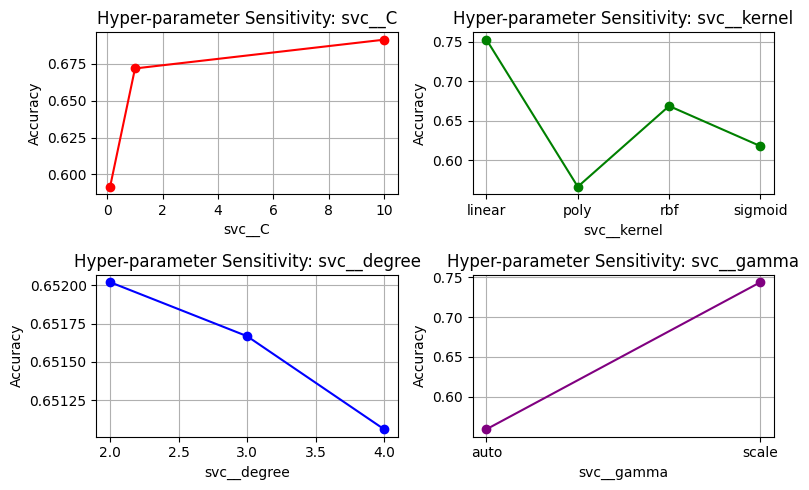

In [149]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract results from GridSearchCV
results = clf.cv_results_
param_values = results['params']
mean_scores = results['mean_test_score']

# Create a DataFrame for easier manipulation
df_results = pd.DataFrame(param_values)
df_results['mean_score'] = mean_scores

# Define the hyper-parameters to analyze
hyperparams = ['svc__C', 'svc__kernel', 'svc__degree', 'svc__gamma']

# Define colors for the plots
colors = ['red', 'green', 'blue', 'purple']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

# Iterate over hyper-parameters and plot sensitivity
for i, (hyperparam, color) in enumerate(zip(hyperparams, colors)):
    row = i // 2
    col = i % 2

    ax = axes[row, col]

    # Group mean scores by hyper-parameter value
    grouped_data = df_results.groupby(hyperparam)['mean_score'].mean()

    # Plot the grouped data with the assigned color
    ax.plot(grouped_data.index, grouped_data.values, marker='o', color=color)

    ax.set_xlabel(hyperparam)
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Hyper-parameter Sensitivity: {hyperparam}')
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [181]:
svm_model_best = SVC(
    C=1, kernel='rbf', gamma='scale', degree=2, class_weight=None
)

metrics_df.loc[len(metrics_df.index)] = evaluate_model("Support Vector Best", svm_model_best, X_train, X_test, y_train, y_test)

In [184]:
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.787362,0.770315,0.787362,0.771113
1,Random Forest,0.749248,0.713914,0.749248,0.702221
2,SVM,0.791374,0.776112,0.791374,0.778368
3,Support Vector Best,0.791374,0.776112,0.791374,0.778368
4,Logistic Regression Best,0.786861,0.771890,0.786861,0.775611


In [130]:
n_classes=np.unique(y_train).shape[0]
n_classes

3

In [139]:
np.unique(y_train)

array(['-1', '0', '1'], dtype=object)

Training Accuracy

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
For fraction 0.05, evaluation accuracy: 0.749498997995992
For fraction 0.1, evaluation accuracy: 0.7773319959879639
For fraction 0.15, evaluation accuracy: 0.7947860962566845
For fraction 0.2, evaluation accuracy: 0.7868605817452357
For fraction 0.25, evaluation accuracy: 0.7841091492776886
For fraction 0.3, evaluation accuracy: 0.7913741223671013
For fraction 0.35, evaluation accuracy: 0.7750071653768988
For fraction 0.39999999999999997, evaluation accuracy: 0.7848006019563581
For fraction 0.44999999999999996, evaluation accuracy: 0.7860008916629514
For fraction 0.49999999999999994, evaluation accuracy: 0.7794943820224719
For fraction 0.5499999999999999, evaluation accuracy: 0.7758526354185665
For fraction 0.6, evaluation accuracy: 0.7779635512456111
For fraction 0.65, evaluation accuracy: 0.7894736842105263
For fraction 0.7, evaluation accuracy: 0.7775867010604758
For fraction 0.75, 

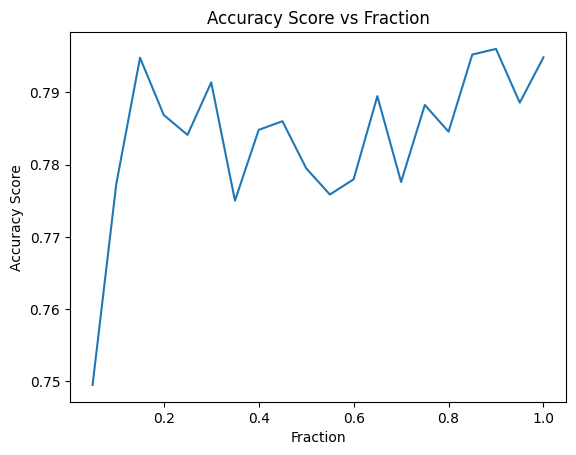

In [156]:
import numpy as np
import matplotlib.pyplot as plt

fractions = np.linspace(0.05, 1.0, 20)  # Generate 20 fractions between 0.05 and 1.0

accuracy_scores = []

print(fractions)

for frac in fractions:
    train_df, test_df = splitData(df_final, frac)
    X_train = np.stack(train_df['embeddings'].values)
    y_train = train_df['sentiment'].values
    X_test = np.stack(test_df['embeddings'].values)
    y_test = test_df['sentiment'].values

    model = train_model(svm_model, X_train, y_train)
    accuracy = evaluate_model(model, X_test, y_test)[0]  # Get the accuracy score
    print("For fraction {}, evaluation accuracy: {}".format(frac, accuracy))
    accuracy_scores.append(accuracy)

# Plot the accuracy scores
plt.plot(fractions, accuracy_scores)
plt.xlabel('Fraction')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Fraction')
plt.show()


In [185]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
def generate_ROC_AUC(name, model, X_train, y_train):
    # Binarize the labels
    y_train_bin = label_binarize(y_train, classes=list(set(y_train)))
    n_classes = y_train_bin.shape[1]

    # Train the model
    model.fit(X_train, y_train)

    # Compute probabilities for each class
    y_score = model.predict_proba(X_train)

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - {}'.format(name))
    plt.legend(loc='lower right')
    plt.show()


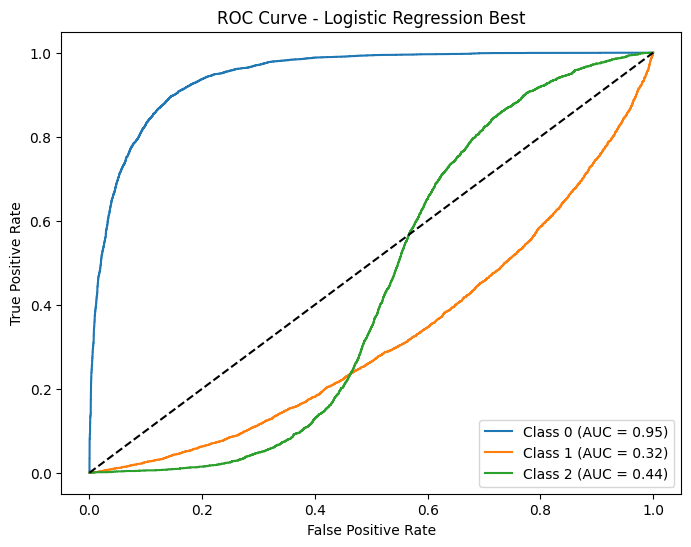

In [186]:
generate_ROC_AUC('Logistic Regression Best',lr_model_best, X_train, y_train)

/home/sairindhri/yelp-data-analysis/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


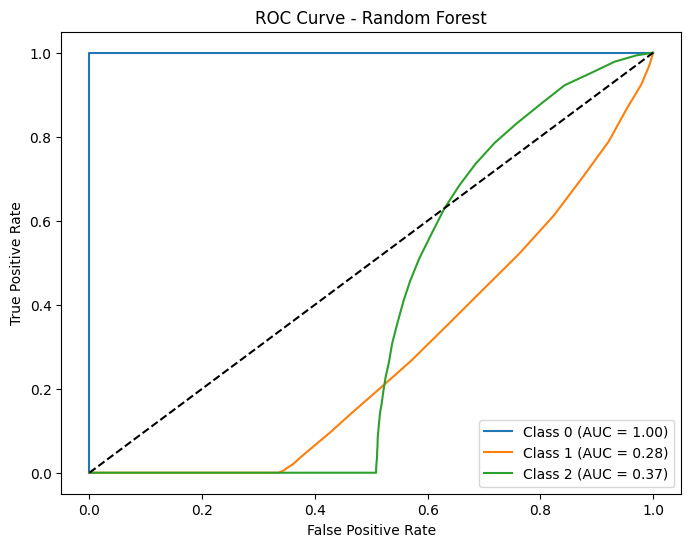

In [187]:
generate_ROC_AUC('Random Forest',rf_model, X_train, y_train)

# Deep Learning Model 

In [258]:
import tensorflow as tf
import tensorflow.keras as keras
import regex as re
from sklearn import preprocessing

In [275]:
enc = preprocessing.OneHotEncoder()
label = train_df['sentiment'].values.reshape ((-1,1))
enc.fit(label)
y_train = enc.transform(label).toarray()
y_train.shape

(79739, 3)

In [276]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [282]:
# Create and train Keras model
n_features=X_train.shape[1]
n_labels = y_train.shape[1]

In [278]:
n_features


384

In [279]:
n_labels

3

In [287]:
from tensorflow.keras.callbacks import EarlyStopping

KERAS_VALIDATION_SPLIT=0.05
KERAS_EPOCHS=100
KERAS_BATCH_SIZE=128

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model = tf.keras.models.Sequential([tf.keras.layers.Dense(1024, input_dim=n_features, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_labels, activation='softmax')
])

LR=0.00001
adam = keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=KERAS_EPOCHS, batch_size=KERAS_BATCH_SIZE, validation_split=KERAS_VALIDATION_SPLIT, callbacks=[early_stopping])

Epoch 1/100
592/592 [==============================] - 2s 2ms/step - loss: 1.0066 - accuracy: 0.6393 - val_loss: 0.9008 - val_accuracy: 0.7091
Epoch 2/100
592/592 [==============================] - 1s 2ms/step - loss: 0.8089 - accuracy: 0.7176 - val_loss: 0.7339 - val_accuracy: 0.7151
Epoch 3/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6946 - accuracy: 0.7282 - val_loss: 0.6615 - val_accuracy: 0.7198
Epoch 4/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6452 - accuracy: 0.7370 - val_loss: 0.6282 - val_accuracy: 0.7334
Epoch 5/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6174 - accuracy: 0.7448 - val_loss: 0.6101 - val_accuracy: 0.7404
Epoch 6/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6021 - accuracy: 0.7495 - val_loss: 0.5993 - val_accuracy: 0.7442
Epoch 7/100
592/592 [==============================] - 1s 2ms/step - loss: 0.5929 - accuracy: 0.7535 - val_loss: 0.5918 - val_accuracy: 0.7489

In [290]:
np.unique(y_test)

array([-1,  0,  1])

In [295]:
from numpy import argmax


def classification_report_neuralmodel(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities into class labels
    y_pred = argmax(y_pred_prob, axis=1)-1

    # Generate and print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, zero_division=1))

def confusion_matrix_neuralmodel(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred_prob = model.predict(X_test)

    # Convert probabilities into class labels
    y_pred = argmax(y_pred_prob, axis=1)-1

    # Generate and print the confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))


In [296]:
classification_report_neuralmodel("Neural Network", model, X_train, X_test, y_train, y_test)
confusion_matrix_neuralmodel("Neural Network", model, X_train, X_test, y_train, y_test)

312/312 [==============================] - 0s 519us/step
Classification Report for Neural Network:
              precision    recall  f1-score   support

          -1       0.81      0.88      0.85      3919
           0       0.54      0.40      0.46      1970
           1       0.84      0.88      0.86      4079

    accuracy                           0.79      9968
   macro avg       0.73      0.72      0.72      9968
weighted avg       0.77      0.79      0.78      9968

312/312 [==============================] - 0s 501us/step
Confusion Matrix for Neural Network:
[[3463  340  116]
 [ 653  785  532]
 [ 161  331 3587]]


# Store SVM model in pickel

In [57]:

import pickle
pickle.dump(svm_model, open('../src/data/svm_sentiment_prediction_model.pkl','wb'))


In [58]:
pickle.dump(df_final,open('../src/data/sentiment_score_df.pkl','wb'))
